# Import Modules

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt

from dataset import *
from ssd import *
from matching import *
from visual import *

# Basic Setting

In [2]:
##############################################################
device = 'cuda' if torch.cuda.is_available() else 'cpu'

VOC2012_CLASSES = (  # always index 0 
#     'background',
    'aeroplane', 'bicycle', 'bird', 'boat','bottle', 
    'bus', 'car', 'cat', 'chair','cow', 
    'diningtable', 'dog', 'horse', 'motorbike', 'person', 
    'pottedplant','sheep', 'sofa', 'train', 'tvmonitor')

VOC2012_ROOT = "../../dataset"

voc = {
    'num_classes': 21,
    'lr_steps': (80000, 100000, 120000),
    'max_iter': 120000,
    'feature_maps': [38, 19, 10, 5, 3, 1],
    'min_dim': 300,
    'steps': [8, 16, 32, 64, 100, 300],
    'min_sizes': [30, 60, 111, 162, 213, 264],
    'max_sizes': [60, 111, 162, 213, 264, 315],
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
    'variance': [0.1, 0.2],
    'clip': True,
    'name': 'VOC',
}

# Loading the Pre-trained SSD300 Model

In [3]:
#################################################################
class SSD300StatsManager(nt.StatsManager):
    def __init__(self):
        super(SSD300StatsManager, self).__init__()
    def summarize(self):
        loss = super(SSD300StatsManager, self).summarize()
        return {'loss': loss}
    
########## MultiBoxLoss Hyper Parameters #####################
overlap_thresh = 0.5
prior_for_matching=True
bkg_label=0
neg_mining=True
neg_pos=3
neg_overlap=0.5 
encode_target=False
alpha = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 32
##############################################################

lr = 1e-5
SSD300_model = build_ssd300(voc['num_classes'], overlap_thresh, prior_for_matching, bkg_label, 
                            neg_mining, neg_pos, neg_overlap, encode_target, alpha, device)
SSD300_model = SSD300_model.to(device)
adam = torch.optim.Adam(SSD300_model.parameters(), lr=lr)
stats_manager = SSD300StatsManager()
exp = nt.Experiment(SSD300_model, [0], [0], adam, stats_manager,\
                  output_dir="../weight/demo", batch_size = batch_size,\
                  perform_validation_during_training=False)
SSD300_model.eval()

SSD300(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (17): Conv2d(25

# Evaluation

Evaluating on cuda ...
Demo Image 
Predictions:
label: 7 ||	 count: 1
score:
 tensor([[0.8629]])
bbox:
 tensor([[0.0163, 0.0064, 0.9813, 0.9834]])
----------------


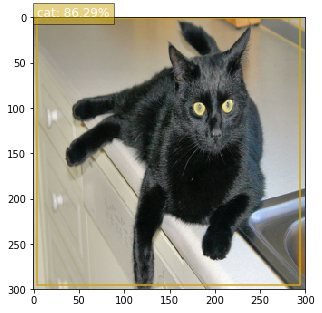

In [4]:
print("Evaluating on {} ...".format(device))
#### change the 'img_path' to your own image
img_path = "../img/2008_007647.jpg"
img = Image.open(img_path).convert('RGB')
img_transform = tv.transforms.Compose([
            tv.transforms.Resize((voc['min_dim'],voc['min_dim'])),
            tv.transforms.ToTensor(),
            ])
img = img_transform(img)
img = img.to(device)
print("================================")
print("================================")
print("================================")
print("Demo Image ")
print("Predictions:")
predict = torch.zeros(1,6)
loc, conf, prior = SSD300_model(img.view(1,3,300,300))
prior = prior.to(device)
softmax = F.softmax(conf.data[0],1)
# decode loc to (x_min, y_min, x_max, y_max)
decode_loc = decode(loc[0], prior, SSD300_model.MultiBoxLoss.variance).view(1,-1,4)
for idx in range(1,21):
    thresh = 0.8
    dets = softmax[:,idx]
    mask_score = dets.gt(thresh).t()
    mask_bbox = dets.gt(thresh).expand(4, dets.size(0)).t()
    score = torch.masked_select(dets, mask_score).view(-1)
    bbox = torch.masked_select(decode_loc.data, mask_bbox).view(-1, 4)
    if bbox.shape[0]!=0:
        keep, count = nms(bbox, score, overlap=0.5, top_k=200)
        class_scores = score[keep[:count]].view(-1,1).to('cpu')
        class_boxes = torch.clamp(bbox[keep[:count]],0,1).to('cpu')
        print("label:",idx-1, "||\t count:",count)
        print('score:\n',class_scores)
        print('bbox:\n',class_boxes)
        print('----------------')
        tmp = torch.ones(count,1)*(idx-1)
        tmp = torch.cat((tmp, class_scores), 1)
        tmp = torch.cat((class_boxes, tmp), 1)
        predict = torch.cat((predict, tmp), 0)
predict = predict[1:]
img = img.to('cpu').numpy()
img = np.moveaxis(img, [0, 1, 2], [2, 0, 1])
plt_Predictions(img, predict, img_path.split('/')[-1].split('.')[0])